In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import matplotlib
import logging

import utils as utils
from matplotlib import cm

In [2]:
runname = 'debug_withC_rogers_netcdfBdy1_EB_soliton_withsponge_focus_finey_summer'
datafilepath = '/Volumes/Tan_2024/SUNTANS/NLIW/iwave2024/dongsha/'+runname+'/data_f_1wave/'

# datafilename = 'sun_out.nc_0000.nc'
datafilename = 'sun_sparse.nc_0000.nc'

# path to saved result
resultfilepath = datafilepath+'/results/'
# path to saved figures
outfilepath = '../figure/'
if not os.path.exists(resultfilepath):
    os.mkdir(resultfilepath)
if not os.path.exists(outfilepath):
    os.mkdir(outfilepath)

param_data = {
    "datafilepath": datafilepath,
    "netcdf_filename": datafilename,
            }
param_result = {
    "resultfilepath": resultfilepath,
    "result_filename": 'sun_out_energy_derived.nc',
            }
idx_end = -15

# Read data

In [3]:
data = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_dissp.nc')
data_ = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'])

# Island center & Shoaling depth

In [4]:
lambdaM2=70.1e3
l_sponge = 20e3
L=1.5*lambdaM2+2*l_sponge
W=1.5*lambdaM2

x_c = 2*l_sponge+1.5*lambdaM2/2 
y_c = W/2

In [5]:
depth_top = 4
depth_shoal = 180
depth_bottom = 600-1e-2

# Section domain into circles & quadrants

In [6]:
# change to radial coordinate
dis_c = np.zeros((len(data.x), len(data.y)))
for i in range(len(data.x)):
    for j in range(len(data.y)):
        dis_c[i,j] = np.sqrt((data.x[i].data-x_c)**2+(data.y[j].data-y_c)**2)
        
theta_c = np.zeros((len(data.x), len(data.y)))
for i in range(len(data.x)):
    for j in range(len(data.y)):
        theta_c[i,j] = np.arctan2(data.y[j].data-y_c, data.x[i].data-x_c)

In [7]:
dis_top = np.mean(dis_c[np.where((data_.depth>=depth_top+.1) & (data_.depth.data<=depth_top+2))])
dis_shoal = np.mean(dis_c[np.where((data_.depth>=depth_shoal-1) & (data_.depth.data<=depth_shoal+1))])
dis_bottom = np.mean(dis_c[np.where((data_.depth>=depth_bottom-1) & (data_.depth.data<depth_bottom))])
quadrants_info = {
    "r_quad": np.array([dis_top, dis_shoal,dis_bottom]),
    "quadrants": ['east', 'north', 'west', 'south'],
    "theta_edge":np.array([-45, 45, 135, -135]),
    "theta_quad": [[-45, 45], [45, 135], [135, -135], [-135, -45]]
            }

In [8]:
# mask out data outside of the inner ring
mask_ring_inner = (dis_c>=quadrants_info["r_quad"][0]) & (dis_c<quadrants_info["r_quad"][1])
mask_ring_inner_east = mask_ring_inner & (theta_c>=quadrants_info["theta_quad"][0][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][0][1]*np.pi/180)
mask_ring_inner_north = mask_ring_inner & (theta_c>=quadrants_info["theta_quad"][1][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][1][1]*np.pi/180)
mask_ring_inner_west = mask_ring_inner & ((theta_c>=quadrants_info["theta_quad"][2][0]*np.pi/180) | (theta_c<quadrants_info["theta_quad"][2][1]*np.pi/180))
mask_ring_inner_south = mask_ring_inner & (theta_c>=quadrants_info["theta_quad"][-1][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][-1][1]*np.pi/180)

# mask out data outside of the outer ring
mask_ring_outer = (dis_c>=quadrants_info["r_quad"][1]) & (dis_c<quadrants_info["r_quad"][-1])
mask_ring_outer_east = mask_ring_outer & (theta_c>=quadrants_info["theta_quad"][0][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][0][1]*np.pi/180)
mask_ring_outer_north = mask_ring_outer & (theta_c>=quadrants_info["theta_quad"][1][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][1][1]*np.pi/180)
mask_ring_outer_west = mask_ring_outer & ((theta_c>=quadrants_info["theta_quad"][2][0]*np.pi/180) | (theta_c<quadrants_info["theta_quad"][2][1]*np.pi/180))
mask_ring_outer_south = mask_ring_outer & (theta_c>=quadrants_info["theta_quad"][-1][0]*np.pi/180) & (theta_c<quadrants_info["theta_quad"][-1][1]*np.pi/180)

# Conversion

## overhead view

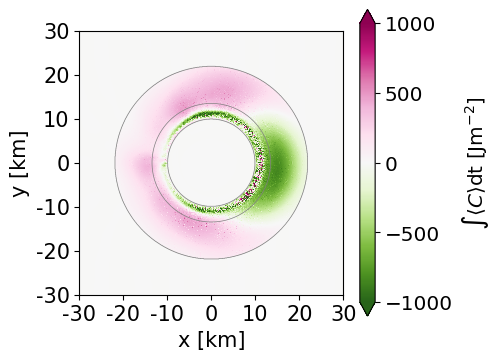

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
im1 = data_.C_int[-1,:,:].T.plot.pcolormesh(ax=ax, vmax=1e3, vmin=-1e3, cmap=cm.PiYG_r, add_colorbar=False)
cb1 = plt.colorbar(im1, location='right', extend='both')
cb1.set_label(label=r"$\int\langle C\rangle$dt [Jm$^{-2}$]", size='x-large')
cb1.ax.tick_params(labelsize='x-large')
ax.contour(data.x.data, data.y.data, data_.depth.data.T, levels = [depth_top, depth_shoal, depth_bottom], colors='0.5', linewidths=.5)

ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
ax.set_xticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_yticklabels(['-30','-20', '-10', '0', '10', '20','30'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(f'')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"C_overhead_summer_f.jpeg", dpi=300)

## energy flux

In [10]:
# https://stackoverflow.com/questions/5328128/scipy-interpolation-of-large-matrix

def interp2d_nearest(X, Y, Z, x, y, spn=3, method='linear'):
    from scipy import interpolate
    xs,ys = map(np.array,(x,y))
    z = np.zeros(xs.shape)
    for i,(x,y) in enumerate(zip(xs,ys)):
        # get the indices of the nearest x,y
        xi = np.argmin(np.abs(X[0,:]-x))
        yi = np.argmin(np.abs(Y[:,0]-y))
        xlo = max(xi-spn, 0)
        ylo = max(yi-spn, 0)
        xhi = min(xi+spn, X[0,:].size)
        yhi = min(yi+spn, Y[:,0].size)
        # make slices of X,Y,Z that are only a few items wide
        nX = X.T[xlo:xhi, ylo:yhi]
        nY = Y.T[xlo:xhi, ylo:yhi]
        nZ = Z[xlo:xhi, ylo:yhi]
        intp = interpolate.interp2d(nX, nY, nZ, method)
        z[i] = intp(x,y)[0]
    return z


In [11]:
data_bc_fx = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_bc_flux_x.nc')
data_bc_fy = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_bc_flux_y.nc')

Fx_prime_int = data_bc_fx.Fx_prime1_int[-1,:,:].data+data_bc_fx.Fx_prime2_int[-1,:,:].data+data_bc_fx.Fx_prime3_int[-1,:,:].data+data_bc_fx.Fx_prime4_int[-1,:,:].data+data_bc_fx.Fx_prime5_int[-1,:,:].data
Fy_prime_int = data_bc_fy.Fy_prime1_int[-1,:,:].data+data_bc_fy.Fy_prime2_int[-1,:,:].data+data_bc_fy.Fy_prime3_int[-1,:,:].data+data_bc_fy.Fy_prime4_int[-1,:,:].data+data_bc_fy.Fy_prime5_int[-1,:,:].data
del data_bc_fx, data_bc_fy

In [12]:
data_bt_f = xr.open_dataset(param_result['resultfilepath']+param_result['result_filename'][:-3]+'_bt_flux.nc')

Fx_0_int = data_bt_f.Fx_01_int[-1,:,:].data+data_bt_f.Fx_02_int[-1,:,:].data+data_bt_f.Fx_03_int[-1,:,:].data+data_bt_f.Fx_04_int[-1,:,:].data
Fy_0_int = data_bt_f.Fy_01_int[-1,:,:].data+data_bt_f.Fy_02_int[-1,:,:].data+data_bt_f.Fy_03_int[-1,:,:].data+data_bt_f.Fy_04_int[-1,:,:].data
del data_bt_f

In [13]:
[xv, yv] = np.meshgrid(data.x.data,data.y.data)
# del data, data_

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_57990/3655352027.py:19: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  intp = interpolate.interp2d(nX, nY, nZ, method)
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_57990/3655352027.py:20: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use 

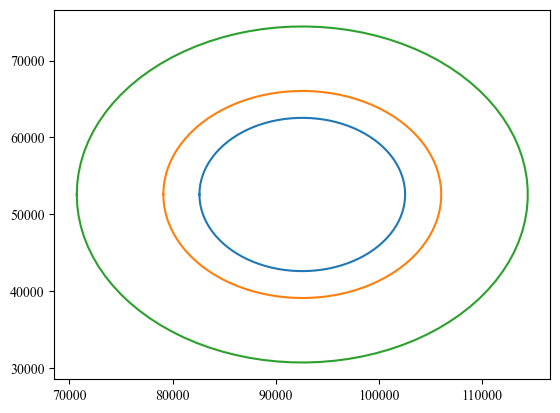

In [14]:
# interp F_prime onto rings and quadrants
x_circles = np.zeros((100, len(quadrants_info["r_quad"])))
y_circles = np.zeros((100, len(quadrants_info["r_quad"])))
Fx_prime_int_ring = np.zeros((100, len(quadrants_info["r_quad"])))
Fy_prime_int_ring = np.zeros((100, len(quadrants_info["r_quad"])))
Fx_0_int_ring = np.zeros((100, len(quadrants_info["r_quad"])))
Fy_0_int_ring = np.zeros((100, len(quadrants_info["r_quad"])))
# circles - small to big
theta_circles = np.linspace(-np.pi,np.pi,100)
for i in range(len(quadrants_info["r_quad"])):
    x_circles[:,i] = quadrants_info["r_quad"][i]*np.cos(theta_circles) + x_c
    y_circles[:,i] = quadrants_info["r_quad"][i]*np.sin(theta_circles) + y_c
    plt.plot(x_circles[:,i],y_circles[:,i])
    Fx_prime_int_ring[:,i] = interp2d_nearest(xv, yv, Fx_prime_int, x_circles[:,i], y_circles[:,i], spn=3, method='linear')
    Fy_prime_int_ring[:,i] = interp2d_nearest(xv, yv, Fy_prime_int, x_circles[:,i], y_circles[:,i], spn=3, method='linear')
    Fx_0_int_ring[:,i] = interp2d_nearest(xv, yv, Fx_0_int, x_circles[:,i], y_circles[:,i], spn=3, method='linear')
    Fy_0_int_ring[:,i] = interp2d_nearest(xv, yv, Fy_0_int, x_circles[:,i], y_circles[:,i], spn=3, method='linear')

/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_57990/3655352027.py:19: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  intp = interpolate.interp2d(nX, nY, nZ, method)
/var/folders/sr/6_bkfhj929364hv72k5pf2jw0000gn/T/ipykernel_57990/3655352027.py:20: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use 

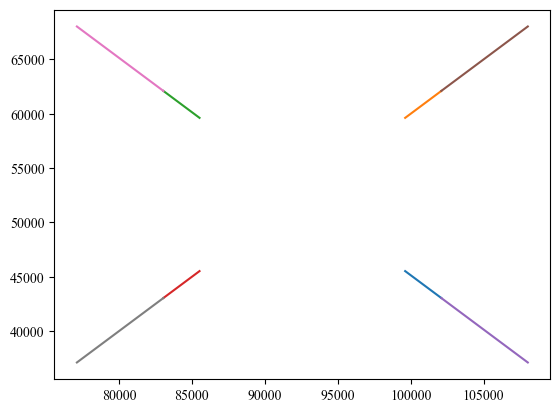

In [15]:
# interp F_prime onto rings and quadrants
x_edges = np.zeros((100, len(quadrants_info["quadrants"]), len(quadrants_info["r_quad"])-1))
y_edges = np.zeros((100, len(quadrants_info["quadrants"]), len(quadrants_info["r_quad"])-1))
Fx_prime_int_edges = np.zeros((100, len(quadrants_info["quadrants"]), len(quadrants_info["r_quad"])-1))
Fy_prime_int_edges = np.zeros((100, len(quadrants_info["quadrants"]), len(quadrants_info["r_quad"])-1))
Fx_0_int_edges = np.zeros((100, len(quadrants_info["quadrants"]), len(quadrants_info["r_quad"])-1))
Fy_0_int_edges = np.zeros((100, len(quadrants_info["quadrants"]), len(quadrants_info["r_quad"])-1))
# edges
for ii in range(len(quadrants_info["r_quad"])-1):
    r_edges = np.linspace(quadrants_info["r_quad"][ii],quadrants_info["r_quad"][ii+1],100)
    for i in range(len(quadrants_info["quadrants"])):
        x_edges[:,i,ii] = r_edges*np.cos(np.pi*quadrants_info["theta_edge"][i]/180) + x_c
        y_edges[:,i,ii] = r_edges*np.sin(np.pi*quadrants_info["theta_edge"][i]/180) + y_c
        plt.plot(x_edges[:,i,ii],y_edges[:,i,ii])
        Fx_prime_int_edges[:,i,ii] = interp2d_nearest(xv, yv, Fx_prime_int, x_edges[:,i,ii], y_edges[:,i,ii], spn=3, method='linear')
        Fy_prime_int_edges[:,i,ii] = interp2d_nearest(xv, yv, Fy_prime_int, x_edges[:,i,ii], y_edges[:,i,ii], spn=3, method='linear')
        Fx_0_int_edges[:,i,ii] = interp2d_nearest(xv, yv, Fx_0_int, x_edges[:,i,ii], y_edges[:,i,ii], spn=3, method='linear')
        Fy_0_int_edges[:,i,ii] = interp2d_nearest(xv, yv, Fy_0_int, x_edges[:,i,ii], y_edges[:,i,ii], spn=3, method='linear')

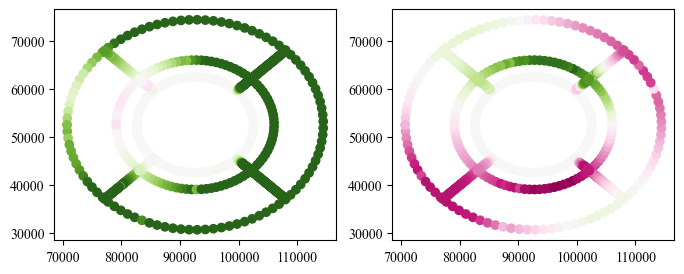

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

ax[0].scatter(x_circles, y_circles, c=Fx_prime_int_ring, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)
ax[0].scatter(x_edges, y_edges, c=Fx_prime_int_edges, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)

ax[1].scatter(x_circles, y_circles, c=Fy_prime_int_ring, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)
ax[1].scatter(x_edges, y_edges, c=Fy_prime_int_edges, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)

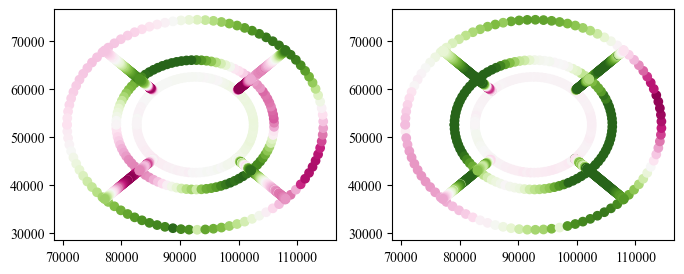

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,3))

ax[0].scatter(x_circles, y_circles, c=Fx_0_int_ring, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)
ax[0].scatter(x_edges, y_edges, c=Fx_0_int_edges, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)

ax[1].scatter(x_circles, y_circles, c=Fy_0_int_ring, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)
ax[1].scatter(x_edges, y_edges, c=Fy_0_int_edges, vmin=-1e7,vmax=1e7, cmap=cm.PiYG_r)

In [18]:
dissip0 = data.dissip0
dissip_prime = data.dissip_prime

# spatially filter dissipation; running mean, binsize = N
N = 10
dissip_prime_filter = dissip_prime[-1,:,:].data.copy()
dissip_0_filter = dissip0[-1,:,:].data.copy()
for i in range(len(data.x)):
    dissip_prime_filter[i,:] = np.convolve(dissip_prime_filter[i,:], np.ones(N)/N, 'same')
    dissip_0_filter[i,:] = np.convolve(dissip_0_filter[i,:], np.ones(N)/N, 'same')
for j in range(len(data.y)):
    dissip_prime_filter[:,j] = np.convolve(dissip_prime_filter[:,j], np.ones(N)/N, 'same')
    dissip_0_filter[:,j] = np.convolve(dissip_0_filter[:,j], np.ones(N)/N, 'same')

In [19]:
x_upstreams = [x_c+40e3, x_c+25e3]
x_downstreams = [x_c-40e3, x_c-25e3]

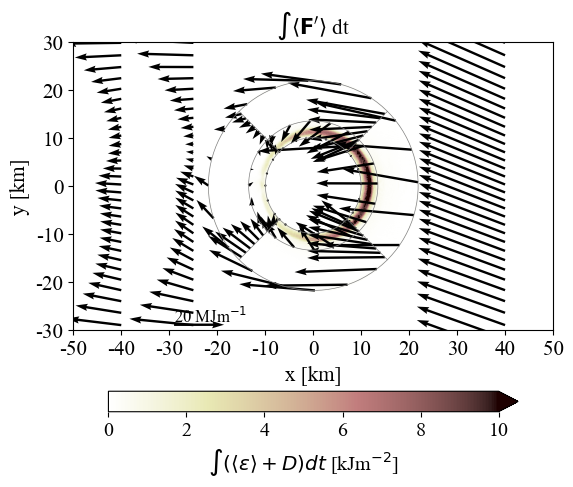

In [20]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,7))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
# im1 = (data.dissip0[-1,:,:]+data.dissip_prime[-1,:,:]).T.plot(ax=ax, vmax=1e4, vmin=0, cmap=cm.Reds, add_colorbar=False)
im1 = ax.pcolormesh(data.x.data, data.y.data, (dissip_prime_filter+dissip_0_filter).T, vmax=1e4, vmin=0, cmap=cm.pink_r)
cb1 = plt.colorbar(im1, shrink=0.8, location='bottom', extend='max', ticks=np.arange(0,1e4+1,2e3))
cb1.set_label(label=r"$\int(\langle\epsilon\rangle+D)dt$ [kJm$^{-2}$]", size='x-large')
cb1.ax.set_xticklabels(['0','2','4','6','8','10'])
cb1.ax.tick_params(labelsize='x-large')
ax.plot(x_circles,y_circles,c='grey',lw=.5)
idx_x = 1020
# ax.plot([data.x[idx_x],data.x[idx_x]],[data.y[0],data.y[-1]],'k',ls='--')
# ax.plot(data.x.data[idx_x], y_c-30000+500,'k^',markersize=10)
# ax.plot(data.x.data[idx_x], y_c+30000-500,'kv',markersize=10)
for ii in range(len(quadrants_info["r_quad"])-1):
    ax.plot(x_edges[:,:,ii],y_edges[:,:,ii],c='grey',lw=.5)
ax.quiver(x_circles[::5,:], y_circles[::5,:], Fx_prime_int_ring[::5,:], Fy_prime_int_ring[::5,:], scale=.4e+8, scale_units='inches', width=5e-3)
ax.quiver(x_edges[::25,:,0], y_edges[::25,:,0], Fx_prime_int_edges[::25,:,0], Fy_prime_int_edges[::25,:,0], scale=.4e+8, scale_units='inches', width=5e-3)
ax.quiver(x_edges[::15,:,1], y_edges[::15,:,1], Fx_prime_int_edges[::15,:,1], Fy_prime_int_edges[::15,:,1], scale=.4e+8, scale_units='inches', width=5e-3)
ax.quiver(x_c-30000+1000, y_c-30000+1000, .2e+8, 0, color='k', scale=.4e+8, scale_units='inches', width=5e-3)
ax.text(x_c-30000+1000, y_c-30000+1500,r'20 MJm$^{-1}$',color='k', fontsize=12)
# ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
# ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
# ax.set_xticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
ax.set_yticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
x_upstream = x_upstreams[0]
ax.quiver(data.x.sel(x=x_upstream, method='nearest').data*np.ones(data.y.data[::30].shape), data.y.data[::30], Fx_prime_int[np.where(data.x.data == data.x.sel(x=x_upstream, method='nearest').data)[0][0], ::30], Fy_prime_int[np.where(data.x.data == data.x.sel(x=x_upstream, method='nearest').data)[0][0], ::30], scale=.4e+8, scale_units='inches', width=5e-3)
# for x_upstream in x_upstreams:
#     ax.quiver(data.x.sel(x=x_upstream, method='nearest').data*np.ones(data.y.data[::30].shape), data.y.data[::30], Fx_prime_int[np.where(data.x.data == data.x.sel(x=x_upstream, method='nearest').data)[0][0], ::30], Fy_prime_int[np.where(data.x.data == data.x.sel(x=x_upstream, method='nearest').data)[0][0], ::30], scale=.4e+8, scale_units='inches', width=5e-3)
for x_downstream in x_downstreams:
    ax.quiver(data.x.sel(x=x_downstream, method='nearest').data*np.ones(data.y.data[::30].shape), data.y.data[::30], Fx_prime_int[np.where(data.x.data == data.x.sel(x=x_downstream, method='nearest').data)[0][0], ::30], Fy_prime_int[np.where(data.x.data == data.x.sel(x=x_downstream, method='nearest').data)[0][0], ::30], scale=.4e+8, scale_units='inches', width=5e-3)
ax.set_xlim([x_c-50000, x_c+50000])
# ax.set_ylim([y_c-50000, y_c+50000])
ax.set_xticks(np.arange(x_c-50000,x_c+50000+1,10000))
# ax.set_yticks(np.arange(y_c-50000,y_c+50000+1,10000))
ax.set_xticklabels(['-50','-40', '-30','-20', '-10', '0', '10', '20','30', '40','50'])
# ax.set_yticklabels(['-50','-40', '-30','-20', '-10', '0', '10', '20','30', '40','50'])

ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title(r"$\int\langle\mathbf{F'}\rangle$ dt", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"Fprime_dissp_int_summer_f.jpeg", dpi=300)

In [21]:
C_int = data_.C_int

# spatially filter dissipation; running mean, binsize = N
N = 10
C_int_filter = C_int[-1,:,:].data.copy()
for i in range(len(data.x)):
    C_int_filter[i,:] = np.convolve(C_int_filter[i,:], np.ones(N)/N, 'same')
for j in range(len(data.y)):
    C_int_filter[:,j] = np.convolve(C_int_filter[:,j], np.ones(N)/N, 'same')

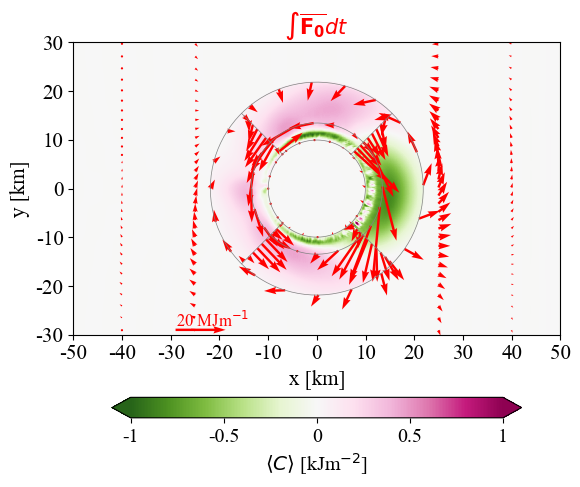

In [22]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,7))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
# im1 = data_.C_int[-1,:,:].T.plot(ax=ax, vmax=1e3, vmin=-1e3, cmap=cm.PiYG_r, add_colorbar=False)
im1 = ax.pcolormesh(data.x.data, data.y.data, C_int_filter.T, vmax=1e3, vmin=-1e3, cmap=cm.PiYG_r)
cb1 = plt.colorbar(im1, shrink=0.8, location='bottom', extend='both', ticks=np.arange(-1e3,1e3+1,5e2))
cb1.set_label(label=r"$\langle C\rangle$ [kJm$^{-2}$]", size='x-large')
cb1.ax.set_xticklabels(['-1','-0.5','0','0.5','1'])
cb1.ax.tick_params(labelsize='x-large')
ax.plot(x_circles,y_circles,c='grey',lw=.5)
idx_x = 1020
# ax.plot([data.x[idx_x],data.x[idx_x]],[data.y[0],data.y[-1]],'k',ls='--')
# ax.plot(data.x.data[idx_x], y_c-30000+500,'k^',markersize=10)
# ax.plot(data.x.data[idx_x], y_c+30000-500,'kv',markersize=10)
for ii in range(len(quadrants_info["r_quad"])-1):
    ax.plot(x_edges[:,:,ii],y_edges[:,:,ii],c='grey',lw=.5)
ax.quiver(x_circles[::5,:], y_circles[::5,:], Fx_0_int_ring[::5,:], Fy_0_int_ring[::5,:], scale=.4e+8, scale_units='inches', width=5e-3, color='r')
ax.quiver(x_edges[::25,:,0], y_edges[::25,:,0], Fx_0_int_edges[::25,:,0], Fy_0_int_edges[::25,:,0], scale=.4e+8, scale_units='inches', width=5e-3, color='r')
ax.quiver(x_edges[::15,:,1], y_edges[::15,:,1], Fx_0_int_edges[::15,:,1], Fy_0_int_edges[::15,:,1], scale=.4e+8, scale_units='inches', width=5e-3, color='r')
ax.quiver(x_c-30000+1000, y_c-30000+1000, .2e+8, 0, color='r', scale=.4e+8, scale_units='inches', width=5e-3)
ax.text(x_c-30000+1000, y_c-30000+1500,r'20 MJm$^{-1}$',color='r', fontsize=12)
# ax.set_xlim([x_c-30000, x_c+30000])
ax.set_ylim([y_c-30000, y_c+30000])
# ax.set_xticks(np.arange(x_c-30000,x_c+30000+1,10000))
ax.set_yticks(np.arange(y_c-30000,y_c+30000+1,10000))
# ax.set_xticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
ax.set_yticklabels(['-30', '-20', '-10', '0', '10', '20', '30'])
for x_upstream in x_upstreams:
    ax.quiver(data.x.sel(x=x_upstream, method='nearest').data*np.ones(data.y.data[::30].shape), data.y.data[::30], Fx_0_int[np.where(data.x.data == data.x.sel(x=x_upstream, method='nearest').data)[0][0], ::30], Fy_0_int[np.where(data.x.data == data.x.sel(x=x_upstream, method='nearest').data)[0][0], ::30], scale=.4e+8, scale_units='inches', width=5e-3, color='r')
for x_downstream in x_downstreams: 
    ax.quiver(data.x.sel(x=x_downstream, method='nearest').data*np.ones(data.y.data[::30].shape), data.y.data[::30], Fx_0_int[np.where(data.x.data == data.x.sel(x=x_downstream, method='nearest').data)[0][0], ::30], Fy_0_int[np.where(data.x.data == data.x.sel(x=x_downstream, method='nearest').data)[0][0], ::30], scale=.4e+8, scale_units='inches', width=5e-3, color='r')
ax.set_xlim([x_c-50000, x_c+50000])
# ax.set_ylim([y_c-50000, y_c+50000])
ax.set_xticks(np.arange(x_c-50000,x_c+50000+1,10000))
# ax.set_yticks(np.arange(y_c-50000,y_c+50000+1,10000))
ax.set_xticklabels(['-50','-40', '-30','-20', '-10', '0', '10', '20','30', '40','50'])
# ax.set_yticklabels(['-50','-40', '-30','-20', '-10', '0', '10', '20','30', '40','50'])
ax.set_aspect('equal')
ax.set_xlabel('x [km]', fontsize=15)
ax.set_ylabel('y [km]', fontsize=15)
ax.set_title("$\int\overline{\mathbf{F_0}}dt$", fontsize=15, color='r')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams["font.family"] = "Times New Roman"
plt.tight_layout()

plt.savefig(outfilepath+ f"F0_C_int_summer_f.jpeg", dpi=300)

## time evolution

In [23]:
C = data_.C_int.differentiate("time",datetime_unit="s")
data["C"]=(['time', 'x', 'y'],  C.data)

In [24]:
C_inner = np.zeros((4, len(data.time)))
C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_inner_east] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_inner[0,:] = C_out_.integrate('y')*1e-6

C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_inner_north] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_inner[1,:] = C_out_.integrate('y')*1e-6

C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_inner_west] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_inner[2,:] = C_out_.integrate('y')*1e-6

C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_inner_south] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_inner[-1,:] = C_out_.integrate('y')*1e-6

In [25]:
C_outer = np.zeros((4, len(data.time)))
C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_outer_east] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_outer[0,:] = C_out_.integrate('y')*1e-6

C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_outer_north] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_outer[1,:] = C_out_.integrate('y')*1e-6

C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_outer_west] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_outer[2,:] = C_out_.integrate('y')*1e-6

C_ = C.copy()
for i in range(len(C_.time)):
    var_ = C_[i,:,:].data
    var_[~mask_ring_outer_south] = 0
    C_[i,:,:] = var_
C_out_ = C_.integrate('x')
C_outer[-1,:] = C_out_.integrate('y')*1e-6

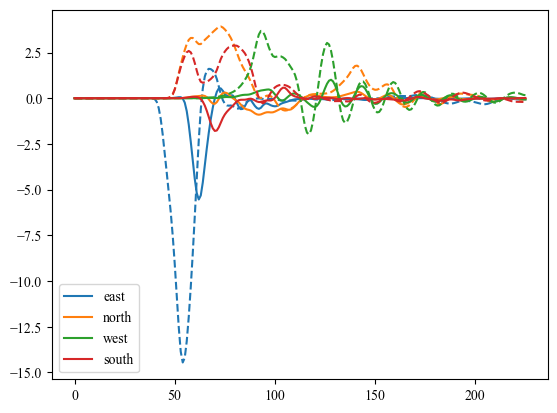

In [26]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
for i in range(4):
    plt.plot(C_inner[i,:], c=colors[i], label=quadrants_info['quadrants'][i])
    plt.plot(C_outer[i,:], '--', c=colors[i])
plt.legend()